In [1]:
!rm -rf gpu_optimization
!git clone https://github.com//Dodilei/gpu_optimization.git

Cloning into 'gpu_optimization'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 91 (delta 49), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (91/91), 124.92 KiB | 551.00 KiB/s, done.
Resolving deltas: 100% (49/49), done.


In [2]:
!pip install pycuda

In [6]:
import pycuda.driver as drv
import pycuda.compiler
from pycuda.gpuarray import vec
import numpy as np
import pycuda.autoinit # This automatically initializes the CUDA driver

# Verify PyCUDA installation
print(f"CUDA driver version: {drv.get_version()}")

# Test if the context was popped by attempting an operation
try:
    # Attempt a simple memory allocation, which requires a valid context
    test_allocation = drv.mem_alloc(np.int32().nbytes)
    print("Context is still active after attempting to pop.")
    # If allocation succeeded, free the memory
    test_allocation.free()
except drv.LogicError as e:
    if "invalid device context" in str(e):
        print("Context was inactive.")
        # Create and push a new context for device 0
        try:
            new_context = drv.Device(0).make_context()
            print("New CUDA context created and activated.")
        except Exception as e:
            print(f"Failed to create new context: {e}")
    else:
        print(f"An unexpected error occurred during context test: {e}")
except Exception as e:
    print(f"An unexpected error occurred during context test: {e}")

# Create two CUDA events
start_event = drv.Event()
end_event = drv.Event()

CUDA driver version: (12, 5, 0)
Context is still active after attempting to pop.


In [7]:
# --- Define Kernel ---
with open("/content/gpu_optimization/aerodinamica_kernel.cu", "r") as f:
    cuda_kernel_code = f.read()

module = pycuda.compiler.SourceModule(cuda_kernel_code, no_extern_c=True)
aerodinamica_kernel = module.get_function("stage_aerodinamica")

In [8]:
# Define coefficients as arrays (PyCUDA can marshal these to float4)
wcl_coeffs_2d = vec.make_float4(*np.array([ 1.34073483e+00,  1.20132980e-01, -1.15990795e-03, -1.22403340e-04], dtype=np.float32))
wcd_coeffs_2d = vec.make_float4(*np.array([ 1.00077421e-02, -9.28183611e-04, -2.03676677e-05,  1.47893318e-05], dtype=np.float32))

In [9]:
# Allocate memory for num_vars on the GPU
num_vars = np.array([
    16,
    16,
    ], dtype=np.int32)
num_vars_gpu = drv.mem_alloc(num_vars.nbytes)
drv.memcpy_htod(num_vars_gpu, num_vars)

# Allocate memory for scale_params on the GPU
scale_params = np.array([
    4.0/16,
    0.75/16,
    ], dtype=np.float32)
scale_params_gpu = drv.mem_alloc(scale_params.nbytes)
drv.memcpy_htod(scale_params_gpu, scale_params)

# Allocate memory for const_params on the GPU
const_params = np.array([
     3.0,
     0.25,
    ], dtype=np.float32)
const_params_gpu = drv.mem_alloc(const_params.nbytes)
drv.memcpy_htod(const_params_gpu, const_params)

# Allocate GPU memory for results
size = int(num_vars.prod(dtype=np.int32))
results_gpu = drv.mem_alloc(size * np.float32().nbytes)

In [10]:
# 3. Launch the kernel
block_size = 256
grid_size = (size + block_size - 1) // block_size

print(f"\n--- Test Launch ---")
print(f"Test size: {size}")
print(f"Test block size: {block_size}")
print(f"Test grid size: {grid_size}")
print(f"Kernel launch: grid=({grid_size}, 1), block=({block_size}, 1, 1)")

start_event.record()

aerodinamica_kernel(
    results_gpu,
    num_vars_gpu,
    scale_params_gpu,
    const_params_gpu,
    wcl_coeffs_2d,
    wcd_coeffs_2d,
    np.float32(0.1016),
    np.float32(-10.06),
    np.float32(5.0),
    np.float32(14.0),
    np.int32(len(num_vars)),
    block=(block_size, 1, 1),
    grid=(grid_size, 1)
)

end_event.record()
end_event.synchronize()
elapsed_time_ms = end_event.time_since(start_event)
print(f"Kernel execution time: {elapsed_time_ms:.3f} ms")

# 4. Copy the data back to the CPU
results_cpu = np.empty(size, dtype=np.float32)
drv.memcpy_dtoh(results_cpu, results_gpu)

print("\nTest results on CPU:", results_cpu)

# Clean up GPU memory
results_gpu.free()
num_vars_gpu.free()
scale_params_gpu.free()
const_params_gpu.free()
print("\nTest GPU memory freed.")


--- Test Launch ---
Test size: 256
Test block size: 256
Test grid size: 1
Kernel launch: grid=(1, 1), block=(256, 1, 1)
Kernel execution time: 1.604 ms

Test results on CPU: [0.3662362  0.36619976 0.36618555 0.36618903 0.36620665 0.36623484
 0.366271   0.36631262 0.36635774 0.36640522 0.36645424 0.36650464
 0.3665565  0.36661047 0.36666796 0.3667302  0.36367974 0.36362875
 0.3636086  0.36361352 0.36363825 0.36367795 0.3637287  0.36378714
 0.36385077 0.3639177  0.36398706 0.3640583  0.36413184 0.36420855
 0.3642902  0.3643788  0.36074716 0.36068147 0.36065552 0.36066195
 0.3606937  0.36074492 0.3608102  0.3608855  0.3609675  0.36105394
 0.36114335 0.36123547 0.36133057 0.36143    0.36153576 0.36165094
 0.35756773 0.35748744 0.35745585 0.35746357 0.35750234 0.35756487
 0.3576446  0.35773656 0.35783675 0.3579425  0.35805193 0.35816452
 0.358281   0.3584027  0.35853243 0.35867363 0.3542354  0.35414082
 0.35410374 0.35411286 0.3541586  0.35423213 0.3543261  0.35443434
 0.35455242 0.3546770

In [11]:
# Attempt to pop the current context
try:
    pycuda.autoinit.context.pop()
    print("Attempted to pop the previous CUDA context.")
except Exception as e:
    print(f"Could not pop context (likely none was active or manageable by autoinit): {e}")

Attempted to pop the previous CUDA context.


<Axes: ylabel='Count'>

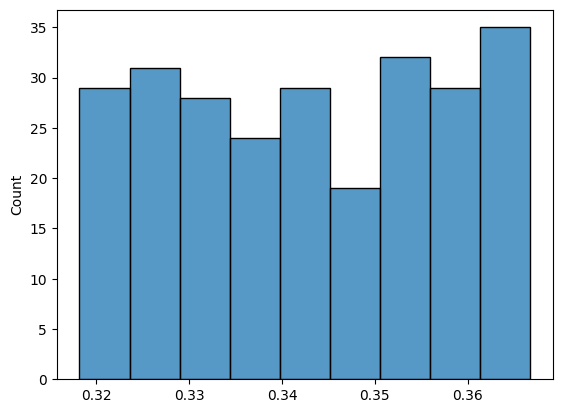

In [12]:
import seaborn as sns
sns.histplot(results_cpu)#, binrange=(0, 5))